In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adagrad, SGD, RMSprop

Data Aquisition and Preprocessing 

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\maxsu\Capstone 3\daily_sunspots_time_series_1850_2023.csv")

# Display the first few rows of the DataFrame
df.head()

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN


Since we have multiple date columns we can drop all but one, as well as the indicator column

In [3]:
df = df.drop(columns=[ 'month', 'day', 'date_frac', 'indicator'])
df.head()

,date,year,counts,std,nobs
0,1850-01-01,1850,253,19.6,1
1,1850-01-02,1850,162,15.5,1
2,1850-01-03,1850,217,18.1,1
3,1850-01-04,1850,99,12.0,1
4,1850-01-05,1850,108,12.6,1


In [4]:
df.isnull().sum()

date      0
year      0
counts    0
std       0
nobs      0
dtype: int64

I will now visualize the data to determine any underlting patterns or cycles in the dataset

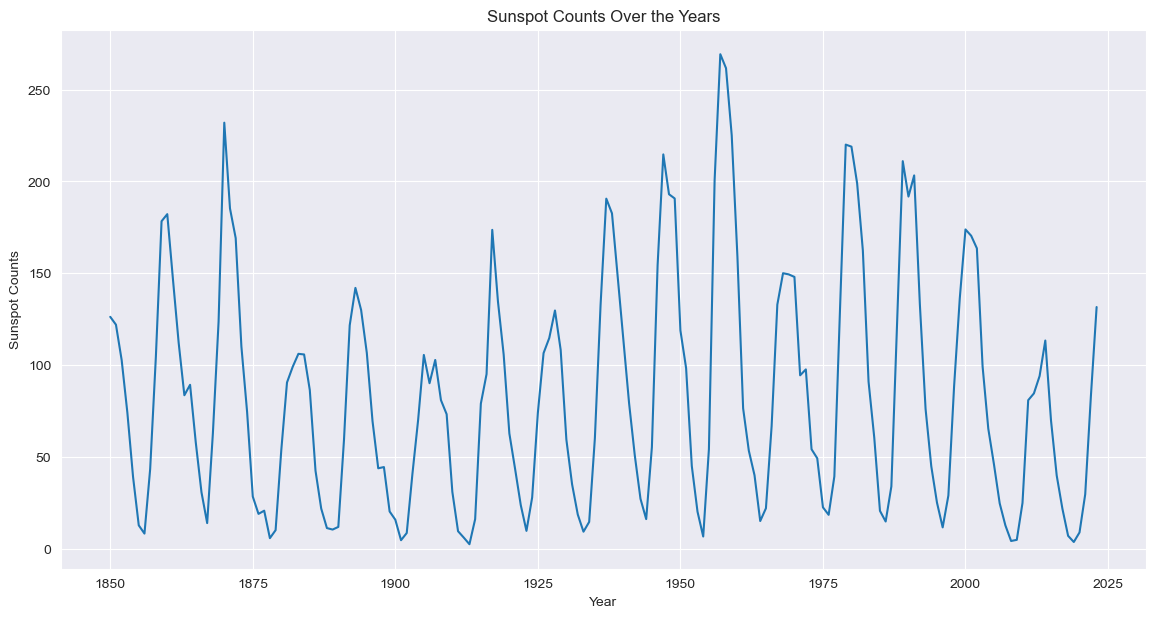

In [5]:
# Distribution of sunspot counts over the years
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))

# Sunspot counts over the years
sns.lineplot(data=df, x='year', y='counts', errorbar=None)

plt.title('Sunspot Counts Over the Years')
plt.xlabel('Year')
plt.ylabel('Sunspot Counts')
plt.show()

This graph illustrates the cyclical nature of sunspots following the roughly 11 year solar cycle of the magnetosphere of the Sun. We can alos see that the peaks of the graph have a highly variability. This is a question for which I hope to be able to answer after this project is concluded. To get potentially deeper insights from this data I will examine the data statistcally and explore the distribution visually using both histograms and boxplots.

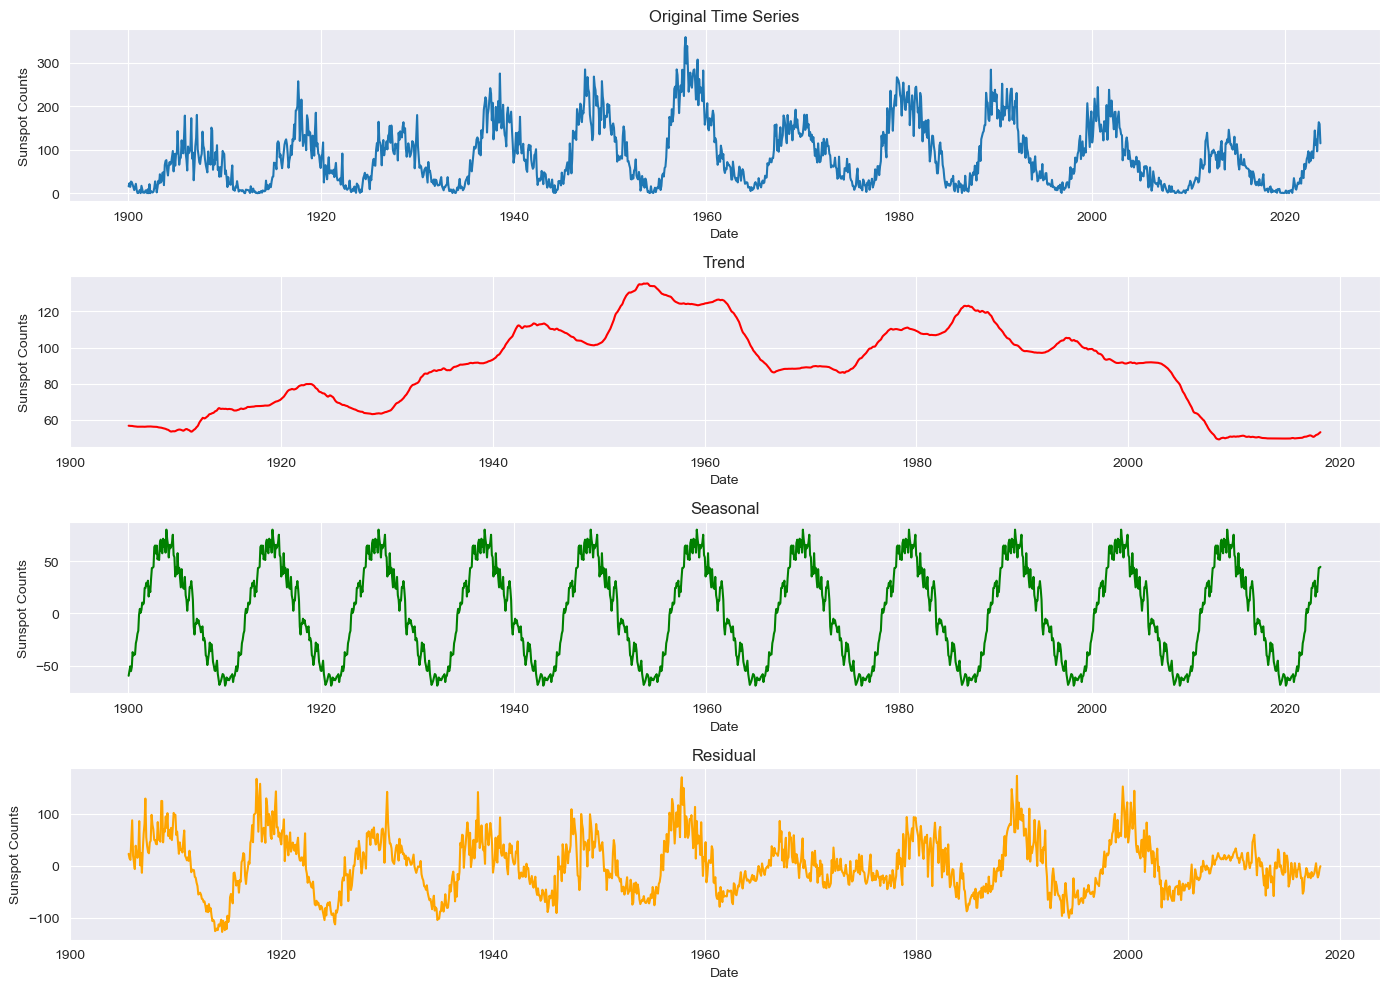

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
monthly_avg = df['counts'].resample('M').mean()

# Decomposing the time series of average sunspot counts(monthly)
decomposition = seasonal_decompose(monthly_avg['1900':'2023'], period=132)  # Using a period of 132 months (11 years) for decomposition

# Plotting components
plt.figure(figsize=(14, 10))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(monthly_avg['1900':'2023'], label='Original')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='orange')
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Sunspot Counts')


plt.tight_layout()
plt.show()

The original time series displays the cyclical nature of sunspots
The trand component shows the long term flucations in the intensity of the solar cycle
The seasonal component displays the 11-year solar cycle
The residual companent displays the noise not captured by the trend or seasonal component.

In [7]:
def load_data(seq_len, series):
    x = []
    y = []
    
    for i in range(seq_len, len(series)):
        x.append(series.iloc[i-seq_len:i, 0])
        y.append(series.iloc[i, 0])
    
    x_train = x[:int(0.9*len(series))]
    y_train = y[:int(0.9*len(series))]
    
    x_test = x[int(0.9*len(series)):]
    y_test = y[int(0.9*len(series)):]
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], seq_len, 1))
    x_test = np.reshape(x_test, (x_test.shape[0], seq_len, 1))
    
    return [x_train,y_train, x_test, y_test]

In [8]:
x_train, y_train, x_test, y_test = load_data(64, df)

print(f'the shape of x_train is {x_train.shape}\nthe shape of y_train is {y_train.shape}\nthe shape of x_test is {x_test.shape}\nthe shape of y_test is {y_test.shape}')

the shape of x_train is (57087, 64, 1)
the shape of y_train is (57087,)
the shape of x_test is (6279, 64, 1)
the shape of y_test is (6279,)


In [9]:
model = ks.models.Sequential([
    ks.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=x_train.shape[-2:]),
    ks.layers.Dense(64, activation='relu'), 
    ks.layers.Dense(32, activation='relu'), 
    ks.layers.Dense(10, activation='relu'),
    ks.layers.Dense(1), 
    ks.layers.Lambda(lambda x: x*250)
    
])
model.summary()

C:\Users\maxsu\anaconda3_new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60, 10)         │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60, 1)          │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 60, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,965 (27.21 KB)

 Trainable params: 6,965 (27.21 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def make_dataset(x, y, buffer_size=1000, batch_size=150):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.cache().shuffle(buffer_size).batch(batch_size)
    return data


In [11]:
train_dataset = make_dataset(x_train, y_train)
test_dataset = make_dataset(x_test, y_test)

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /22))
optimizer = tf.keras.optimizers.SGD( momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_dataset, epochs=100, verbose=0)

In [23]:
#tf.random.set_seed(51)
#np.random.seed(51)


model = ks.models.Sequential([
    ks.layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=x_train.shape[-2:]), 
    ks.layers.Dense(64, activation='relu'), 
    ks.layers.Dense(32, activation='relu'),
    ks.layers.Dense(10, activation='relu'),
    ks.layers.Dense(1), 
    ks.layers.Lambda(lambda x: x*250)
    
])
model.compile(loss=ks.losses.Huber(),metrics=['mae'])
history = model.fit(train_dataset, epochs=10)

Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 4001.5178 - mae: 4002.0249
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 381.2088 - mae: 381.7090
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 343.2585 - mae: 343.7592
Epoch 4/10
 58/381 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 196.0067 - mae: 196.5059

KeyboardInterrupt: 

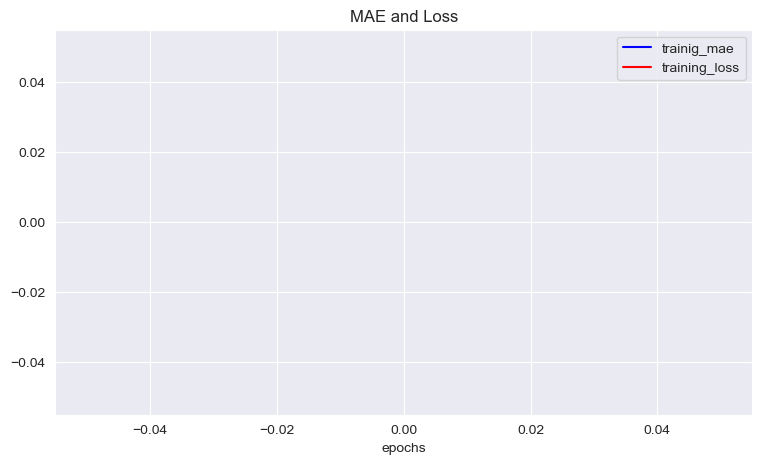

In [17]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(9, 5))
plt.plot(epochs[400:], mae[400:], color='blue', label='trainig_mae')
plt.plot(epochs[400:], loss[400:], color='red', label='training_loss')
plt.title('MAE and Loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [18]:
forecast = model.predict(x_test)
forecast.shape

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(6279, 60, 1)

In [19]:
result = []
for i in forecast[:, 0, 0]:
    result.append(i)
result = np.array(result)
result.shape

(6279,)

In [20]:
print(f'the mean absolute error of the model is {metrics.mean_absolute_error(y_test, result)}')

print(f'the rmse of the mode is {metrics.r2_score(y_test,result)}')

the mean absolute error of the model is 86.10681597543648
the rmse of the mode is -299.23439155297064


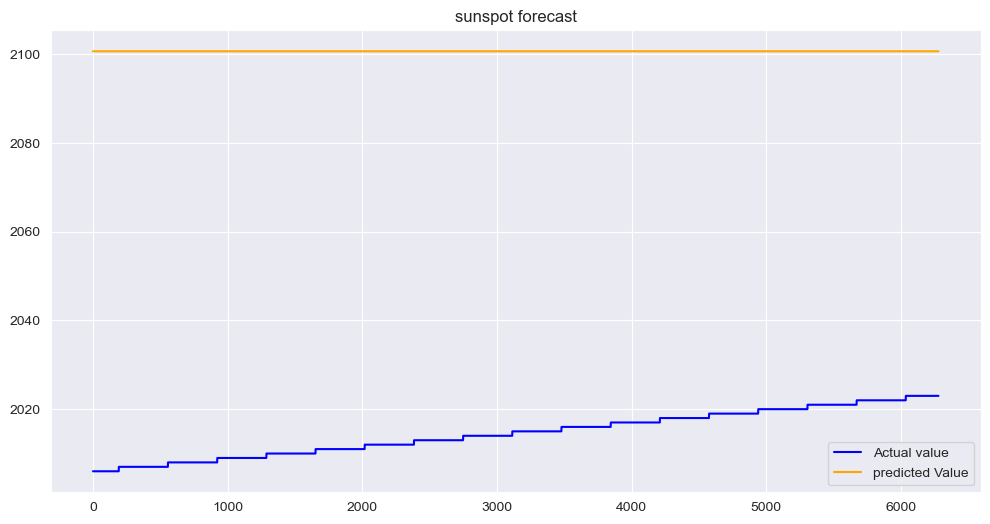

In [21]:
def plot_forecast(test, prediction):
    plt.figure(figsize=(12, 6))
    plt.plot(test,color='blue', label='Actual value')
    plt.plot(prediction, color='orange', label='predicted Value')
    plt.title('sunspot forecast')
    plt.legend()
    plt.show()
plot_forecast(y_test, result)